# Deep Technical Analysis with Coinmarketcap.com Price History

In this notebook we well generate a 3 dimensional price tensor of coin history data. The price tensor will be of dimensions mxnxf. Where m is number of coins, n is number of days, and f is number of features.

Once we have our price tensor, we will implement stochastic batch learning (SBL). SBL will iteratively sample n<sub>b</sub> days of history for a random coin, beginning at a random time t<sub>b</sub>, and ending at t<sub>b</sub> + n<sub>b</sub> + 1. Given such a sample, the algo will train from t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub>, and will attempt to predict t<sub>b</sub> + n<sub>b</sub> + 1.

Price data in t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub> will be normalized with respect to closing price at t<sub>b</sub> + n<sub>b</sub> + 1

The architecture will be an implementation of the mini-machine topology, using CNN as outlined in [this paper](https://arxiv.org/pdf/1706.10059.pdf)

### Creating The Price Tensor

In [215]:
from Coinmarketcap.coinmarketcap import CoinMarketcap
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
# Get a list of coin objects for the top 100 coins from coinmarketcap.com
cmk = CoinMarketcap()
coins = cmk.coins()

In [230]:
# Change 'read_history' to 'get_history' to refresh your local cache
start, end = '20140101', '20180228'
price_tensor = {coin.name:coin.read_history(start=start,end=end) for coin in coins}
price_tensor = pd.Panel(price_tensor)

In [231]:
price_tensor.isna().sum()

,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Unnamed: 0,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Date,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Open,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
High,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Low,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Close,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Volume,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Market Cap,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450


In [232]:
price_tensor.shape

(100, 1520, 8)

### Fill Missing Values

In [242]:
for coin in price_tensor:
    price_tensor[coin]['Date'] = price_tensor['Bitcoin']['Date']
price_tensor = price_tensor.fillna(0)

# Some missing values are encoded with '-'
price_tensor = price_tensor.replace('-', np.nan)
#price_tensor.ffill()

/home/shawn/.virtualenvs/733Project/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


### Plotting All Marketcaps

/home/shawn/.virtualenvs/733Project/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


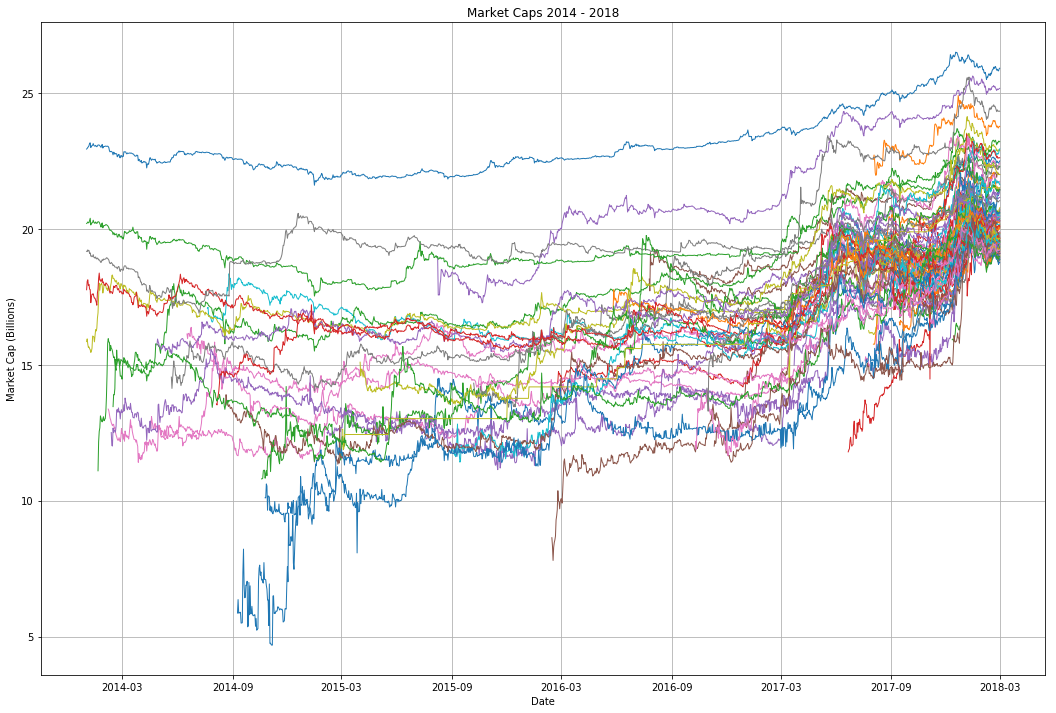

In [261]:
#x = btc_history['dt']
#y = btc_history['Market Cap'] / 1e9
plt.clf()
plt.figure(figsize=(18,12))
x = pd.to_datetime(price_tensor['Bitcoin']['Date'])
for coin in price_tensor.items:
    y = np.log(pd.to_numeric(price_tensor[coin]['Market Cap']))
    plt.plot(x, y, linewidth=1, label=coin)

plt.xlabel('Date')
#plt.xticks(np.arange(1900, 2020, 10.0))
plt.ylabel('Market Cap (Billions)')
plt.title("Market Caps 2014 - 2018")
#plt.legend(loc='upper left')
plt.grid(True)